# Lab 2 - K-means на кривой доходности U.S. Treasury

- Датасет тот же, что в ЛР‑1

Краткий повтор задачи:
1. К текущему датасету добавить новый аттрибут (аттрибуты).
2. "Причесать" датасет: удалить выбросы, дубли, обработать пропущенные значения и т.д.
3. Построить графики зависимости одной переменной от другой, описать кластеры, построить несколько разных графиков, найти ярковыраженные группы.
4. Сделать выводы.

In [ ]:
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import silhouette_score

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 160)

FRED_SERIES = {
    "3M":  "DGS3MO",
    "2Y":  "DGS2",
    "5Y":  "DGS5",
    "10Y": "DGS10",
    "30Y": "DGS30",
}


In [2]:
# загрузка локальных данных, как в прошлой лабе
local_frames = []
date_candidates = ["observation_date", "observationDate", "observationdate", "DATE", "Date", "date"]
for label, sid in FRED_SERIES.items():
    fname = f"{sid}.csv"
    if not os.path.exists(fname):
        continue
    tmp = pd.read_csv(fname)
    date_col = next((c for c in date_candidates if c in tmp.columns), None)
    if date_col is None:
        continue
    val_col = sid if sid in tmp.columns else next((c for c in tmp.columns if c != date_col), None)
    tmp[val_col] = pd.to_numeric(tmp[val_col].replace('.', np.nan), errors='coerce')
    tmp[date_col] = pd.to_datetime(tmp[date_col])
    tmp = tmp.rename(columns={val_col: label})
    tmp = tmp.set_index(date_col)[[label]]
    tmp = tmp[~tmp.index.duplicated(keep='first')] # удаляем дубли в исходной серии, если есть
    local_frames.append(tmp)

# пересечение дат всех серий
all_idx = None
for frame in local_frames:
    all_idx = frame.index if all_idx is None else all_idx.intersection(frame.index)
trimmed_frames = [f.reindex(all_idx) for f in local_frames]
# объединяем
df = pd.concat(trimmed_frames, axis=1, join='inner').sort_index().reset_index()
# приводим имя колонки с датой
for cand in date_candidates:
    if cand in df.columns:
        df = df.rename(columns={cand: 'Date'})
        break
# убираем дубли по дате, если вдруг остались
if 'Date' in df.columns:
    df = df.drop_duplicates(subset=['Date']).sort_values('Date').reset_index(drop=True)

print("Колонки:", df.columns.tolist())
df.head()

Колонки: ['Date', '3M', '2Y', '5Y', '10Y', '30Y']


,Date,3M,2Y,5Y,10Y,30Y
0,1981-09-01,17.01,16.78,16.12,15.41,14.70
1,1981-09-02,16.65,16.78,16.09,15.40,14.70
2,1981-09-03,16.96,16.90,16.14,15.48,14.82
3,1981-09-04,16.64,16.89,16.17,15.51,14.84
4,1981-09-07,NaN,NaN,NaN,NaN,NaN


In [3]:
# здесь делаем ограниченное заполнение (праздники и короткие пропуски)
DF_FILL_LIMIT = 3
if "Date" in df.columns:
    df = df.sort_values("Date").reset_index(drop=True)
    df = df.set_index("Date").sort_index()

num_cols = [c for c in df.columns]
df[num_cols] = df[num_cols].ffill(limit=DF_FILL_LIMIT).bfill(limit=DF_FILL_LIMIT)

# вернём Date назад в колонки
if isinstance(df.index, pd.DatetimeIndex):
    df = df.reset_index()
df = df.sort_values("Date").reset_index(drop=True)
df.head()

,Date,3M,2Y,5Y,10Y,30Y
0,1981-09-01,17.01,16.78,16.12,15.41,14.70
1,1981-09-02,16.65,16.78,16.09,15.40,14.70
2,1981-09-03,16.96,16.90,16.14,15.48,14.82
3,1981-09-04,16.64,16.89,16.17,15.51,14.84
4,1981-09-07,16.64,16.89,16.17,15.51,14.84


#### Добавим новые атрибуты
По заданию нужно добавить не менее одного атрибута, мы добавим атрибуты по списку ниже:
- level - средний уровень длинных ставок (mean(5Y, 10Y, 30Y))
- slope_10y_2y - наклон кривой 10Y - 2Y
- curv - кривизна (2*10Y-2Y-30Y)
- d10y - дневное изменение 10летней ставки
- vol10 - 10 дневная волатильность d10y

In [4]:
df_feat = df.copy()
df_feat["level"] = df_feat[["5Y", "10Y", "30Y"]].mean(axis=1)
df_feat["slope_10y_2y"] = df_feat["10Y"] - df_feat["2Y"]
df_feat["curv"] = 2*df_feat["10Y"] - df_feat["2Y"] - df_feat["30Y"]
df_feat["d10y"] = df_feat["10Y"].diff()
df_feat["vol10"] = df_feat["d10y"].rolling(10).std()

# убираем строки с NaN в новых признаках
df_feat = df_feat.dropna().reset_index(drop=True)

Далее что сделаем:
- удалим редкие экстремальные выбросы по d10y
- проверим дубли дат (уже убраи выше)
- построим несколько диаграмм рассеяния и визуально обсудим "группы"

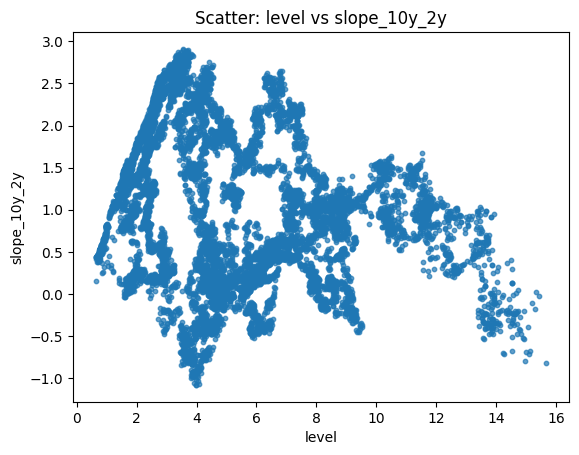

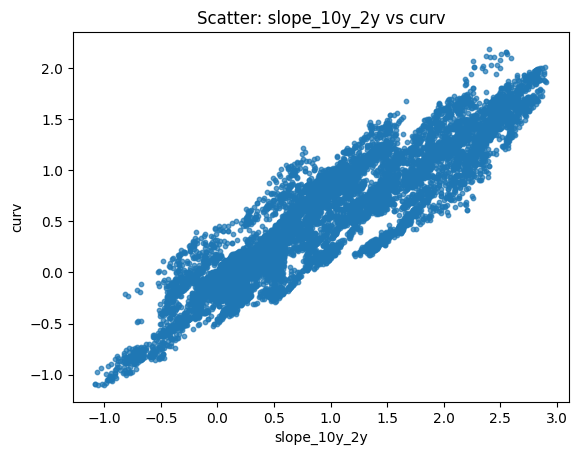

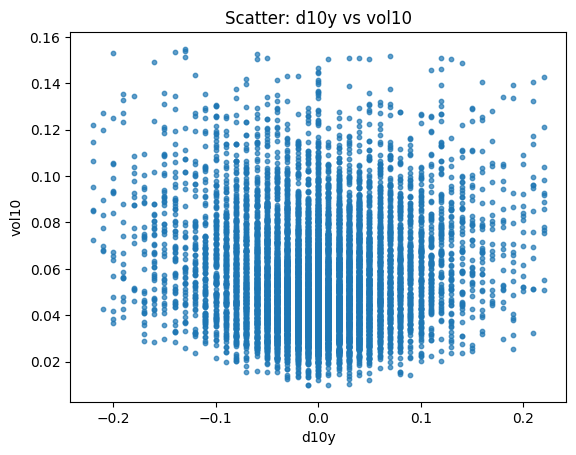

In [ ]:
# ПРИЧЕСЫВАНИЕ (дубли дат уже убраны выше)
# MAD-фильтр по d10y и vol10 
df_feat = df_feat.copy()
df_feat["vol10"] = df_feat["d10y"].shift(1).rolling(10, min_periods=10).std()
df_feat = df_feat.dropna(subset=["vol10"])

def z_mad(s, thr=5.0):
    m = s.median()
    d = (s - m).abs().median() or 1.0
    return 0.6745 * (s - m).abs() / d <= thr

mask = z_mad(df_feat["d10y"]) & z_mad(df_feat["vol10"])
df_feat = df_feat.loc[mask].reset_index(drop=True)

pairs = [("level","slope_10y_2y"), ("slope_10y_2y", "curv"), ("d10y", "vol10")]
for xcol, ycol in pairs:
    plt.figure()
    if xcol == "d10y" and ycol == "vol10":
        hb = plt.hexbin(df_feat[xcol], df_feat[ycol], gridsize=60, cmap='Blues', mincnt=1)
        plt.colorbar(hb, label='count')
        plt.xlabel(xcol)
        plt.ylabel(ycol)
        plt.title(f"Hexbin: {xcol} vs {ycol}")
    else:
        plt.scatter(df_feat[xcol], df_feat[ycol], s=10, alpha=0.7)
        plt.xlabel(xcol)
        plt.ylabel(ycol)
        plt.title(f"Scatter: {xcol} vs {ycol}")
    plt.show()

- level\slope_10y_2y:
Явная отрицательная связь, при низком уровне ставок наклон положительный и большой (мягкая политика/период слабой экономики), при высоком уровне - уходит к нулю и отрицательным значениям. Точки идут дугами - следствие временного движения (фазы ужесточения).
- slope_10y_2y\curv:
Крайне высокая линейность, почему так: curv =  slope_10y_2y - спред(30Y–10Y). Если спред колеблется около стабильных значений - получаем сильную корреляцию.
- d10y\vol10:
Симметричное облако (вокруг d10y=0),в среднем положительные и отрицательные ходы при одинаковой волатильности. "гребенка" - это квантизация d10y, никакой ошибки нет, доходности округлены до 1б.п., разности тоже дискретные.

In [6]:
features = ["level", "slope_10y_2y", "curv", "vol10"]
X = df_feat[features].values

# масштабируем с robust скейлером
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

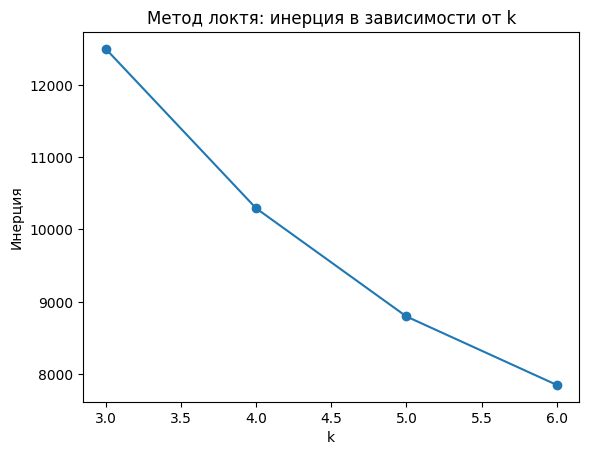

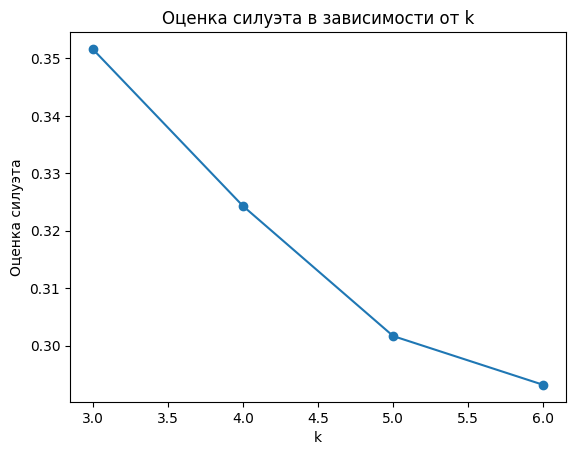

Лучшее k по оценке силуэта: 3


In [7]:
k_grid = range(3,7)
iner, sil = [], []

for k in k_grid:
    km = KMeans(n_clusters=k, n_init=20, random_state=42)
    labels = km.fit_predict(X_scaled)
    iner.append(km.inertia_)
    sil.append(silhouette_score(X_scaled, labels))


plt.figure()
plt.plot(list(k_grid), iner, marker="o")
plt.title("Метод локтя: инерция в зависимости от k")
plt.xlabel("k")
plt.ylabel("Инерция")
plt.show()


plt.figure()
plt.plot(list(k_grid), sil, marker="o")
plt.title("Оценка силуэта в зависимости от k")
plt.xlabel("k")
plt.ylabel("Оценка силуэта")
plt.show()

k_list = list(k_grid)
best_k = k_list[np.argmax(sil)]
print("Лучшее k по оценке силуэта:", best_k)

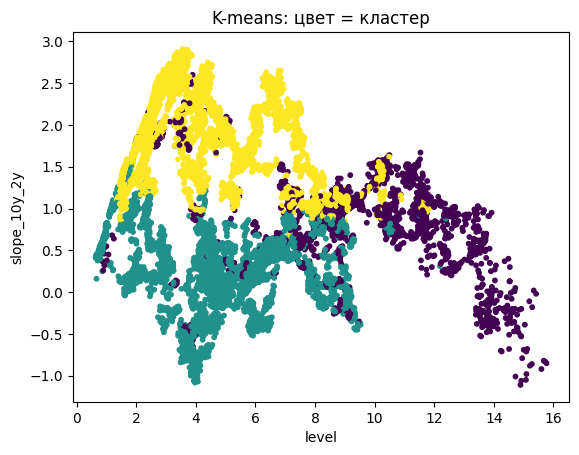

центры (масштабированы):


,level,slope_10y_2y,curv,vol10
cluster_0,1.162208,-0.077909,0.202119,1.562343
cluster_1,-0.002435,-0.425227,-0.522778,-0.191991
cluster_2,-0.074743,0.742426,0.651307,0.096847



Центры (исходный масштаб):


,level,slope_10y_2y,curv,vol10
cluster_0,9.586681,0.766381,0.687971,0.098484
cluster_1,4.656359,0.304448,0.013816,0.046172
cluster_2,4.350254,1.857427,1.105716,0.054785


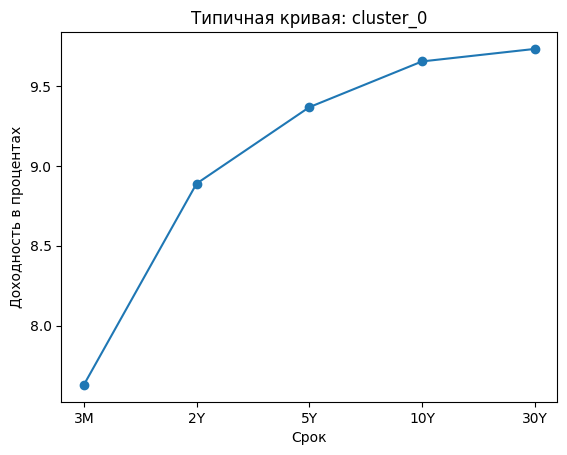

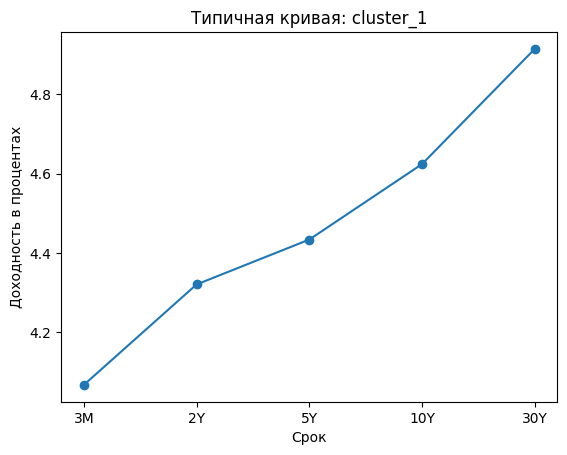

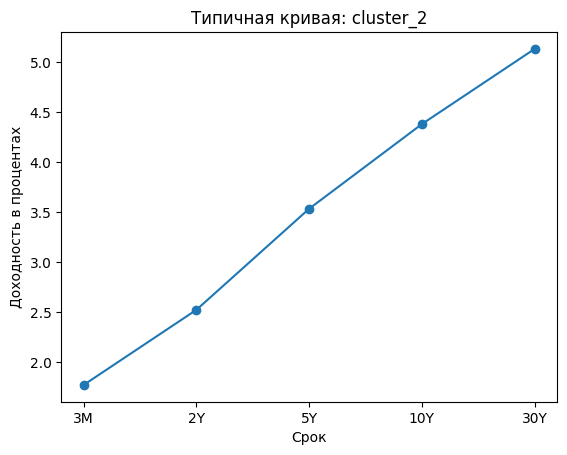

In [8]:
k = best_k
km=KMeans(n_clusters=k, n_init=20, random_state=42)
labels = km.fit_predict(X_scaled)
df_feat["cluster"] = labels

# Визуализация кластеров на одном из скаттер-полей
plt.figure()
plt.scatter(df_feat["level"], df_feat["slope_10y_2y"], c=df_feat["cluster"], s=10)
plt.xlabel("level"); plt.ylabel("slope_10y_2y")
plt.title("K-means: цвет = кластер")
plt.show()

# центры в пространстве признаков
centers = pd.DataFrame(km.cluster_centers_, columns=features, index=[f"cluster_{i}" for i in range(k)])
# обратно преобрзауем к исходному масштабу
centers_unscaled = pd.DataFrame(scaler.inverse_transform(km.cluster_centers_), columns=features, index=centers.index)

print("центры (масштабированы):")
display(centers)
print("\nЦентры (исходный масштаб):")
display(centers_unscaled)

#
tenors = ["3M", "2Y", "5Y", "10Y", "30Y"]
curve_centers = {}
for c in range(k):
    subset = df_feat[df_feat["cluster"]==c][tenors]
    curve_centers[f"cluster_{c}"] = subset.mean()

curve_centers = pd.DataFrame(curve_centers)
for cname in curve_centers.columns:
    plt.figure()
    plt.plot(tenors, curve_centers[cname].values, marker="o")
    plt.xlabel("Срок")
    plt.ylabel("Доходность в процентах")
    plt.title(f"Типичная кривая: {cname}")
    plt.show()


Вывод:
- По диаграммам видны три кластера, что согласуется с полученным K=3:
    - Кластер 0 - высокий уровень,крутой  положительный наклон. Кривая восходящая, соответствует периодам высокой инфляции/ранним фазам подьема, когда ФРС быстро повышала ставки. ЗМ заметно ниже длинных сроков.
    - Кластер 1 - средний уровень, местами более плоская кривая. 3М близок по доходности с облигациями на долгий срок.
    - Кластер 2 - низкий уровень, ставки 3М ниже 2%, соответствует эпохе 2009-2015 годов.
    - K=3 дает лучший баланс компактности/разделимости, поэтому выбрали его.